<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/OnlyCNN%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 2890, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 2890 (delta 8), reused 510 (delta 1), pack-reused 2364
Receiving objects: 100% (2890/2890), 403.54 MiB | 29.05 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Checking out files: 100% (2380/2380), done.
/content/STAT3007_Project


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio


In [3]:
# produce emotion label

# 0 - calm; 1 - happy; 2 - sad; 3 - angry; 4 - surprised
target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}

def target_generation(file_name):
  labels = file_name.split('.')[0].split('-')
  emotion = labels[0]

  if emotion not in target_map:
    return None

  return target_map[emotion]

# Feature generation
First, we seek to generate a feature to use. We use mel-spectrogram which is more efficient than just spectrogram. It takes into account of how human perceives frequencies in a non-linear scale.https://www.youtube.com/watch?v=9GHCiiDLHQ4


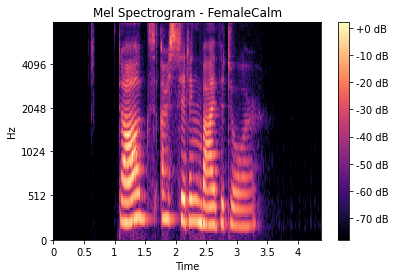

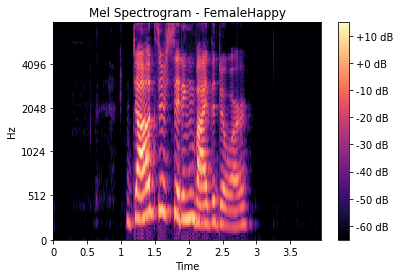

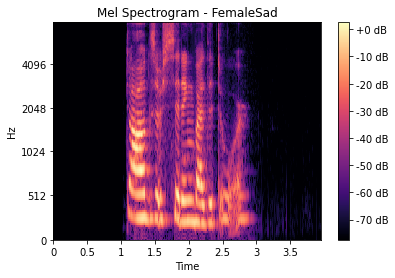

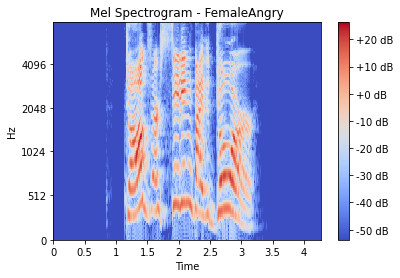

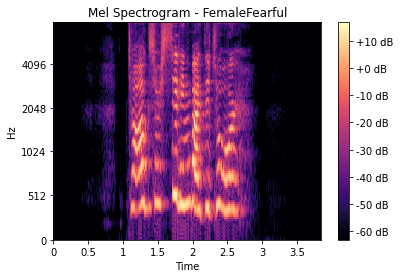

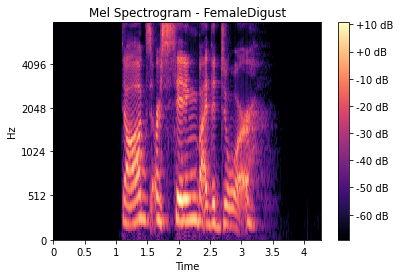

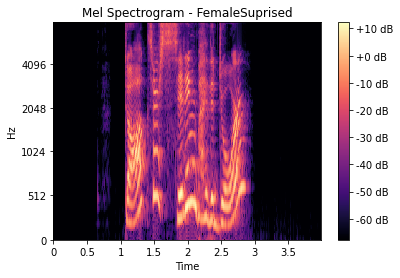

In [4]:
# this shows the mel-spectrogram of different emotion in one exmaple
emo = ['Calm','Happy','Sad','Angry','Fearful','Digust','Suprised']
for i in range(2,9):
  file_path ='/content/STAT3007_Project/Audio_Speech_Actors_01-24/Female/Actor_02/0'+str(i)+'-02-02-01-02.wav'
  sample, test_rate = librosa.load(file_path,sr = 48000)

  spectrogram = librosa.feature.melspectrogram(y=sample, sr=test_rate, n_mels=128,fmax=8000,hop_length=int(0.01*test_rate), window = 'hamming',win_length = int(0.02*test_rate)) 
  spectrogram = librosa.power_to_db(spectrogram)

  plt.figure()
  librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time', sr =test_rate);
  plt.title('Mel Spectrogram - Female' + emo[i-2])
  plt.colorbar(format='%+2.0f dB');

Let's write that as a function

In [5]:
# mel_decomposition
def mel_spectral_decomposition(sample,sampling_rate, title = ' title placeholder', visualise = False):

  spectrogram = librosa.feature.melspectrogram(y=sample, sr=sampling_rate, n_mels=128,fmax=8000) 
  spectrogram = librosa.power_to_db(spectrogram)

  if visualise:
    librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time', sr =sampling_rate);
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')

  return spectrogram

# Pre-Process

## Audio Slience Truncating
We observe that there is radio slience before and after the actual speech. So we have to truncate them all. We do this by truncating
1. all the time steps below a certain threshold before a certain time step
2. all the time steps after the last time step above the threshold.

Threshold: $10^{-3}$

Helper function at the end of this session

In [6]:
# final function
def truncate_silence(sample):
  speech = np.where(abs(sample) > 1e-3)

  start = speech[0][0]
  end = speech[0][-1]

  return sample[start:end+1]

In [7]:
test_sample, test_rate = librosa.load('/content/STAT3007_Project/Audio_Speech_Actors_01-24/Female/Actor_08/05-02-01-02-08.wav', sr= None)

Text(0.5, 1.0, 'truncated')

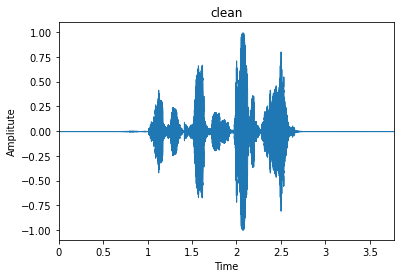

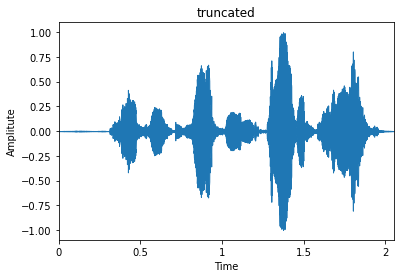

In [8]:
plt.figure()
display.waveplot(y = test_sample, sr = test_rate)
plt.ylabel('Amplitute')
plt.title('clean')

plt.figure()
display.waveplot(y = truncate_silence(test_sample), sr = test_rate)
plt.ylabel('Amplitute')
plt.title('truncated')

## Normalise waveform


In [9]:
def amp_normalisation(sample):
  mean = np.mean(sample)
  std = np.sqrt(np.var(sample))
  return (sample - mean)/std

In [10]:
# we often truncate it then normalise it
truncate_test = truncate_silence(test_sample)
norm_test = amp_normalisation(truncate_test)

## Padding

In [11]:
# find maximum and minimum duration
def find_min_max():

  min_time = 41241
  max_time = 0
  min_sample = 0
  max_sample = 0
  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        # we want only audio files, selected emotions and strong intensity
        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue
        
        sample, sampling_rate = librosa.load(sample_path, sr = None)

        sample = truncate_silence(sample)

        sampling_time = sample.shape[0]/sampling_rate

        if sampling_time < min_time:
          min_time = sampling_time
          min_sample = sample.shape[0]
          min_file = sample_name

        if sampling_time > max_time:
          max_time = sampling_time
          max_sample = sample.shape[0]
          max_file = sample_name

  return min_time, max_time, min_sample, max_sample, min_file, max_file

In [12]:
min_time, max_time, min_sample, max_sample,min_file,max_file = find_min_max()


Now that we have the maximum duration of the dataset, we can start pre-padding

In [13]:
def pre_pad(samples, max_sample):
  sample_duration = samples.shape[0]

  num_to_pad = max_sample - sample_duration
  padded_sample = np.pad(samples,(num_to_pad,0),'constant', constant_values = 0)

  return padded_sample

let's inspect how all the pre-processing works by choosing a random file and inspect the padded spectrogram

In [14]:
test_sample_tr = truncate_silence(test_sample)
test_sample_tr = amp_normalisation(test_sample_tr)
test_sample_pad = pre_pad(test_sample_tr, max_sample)

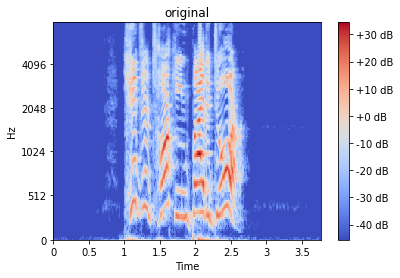

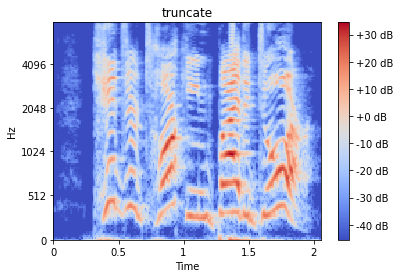

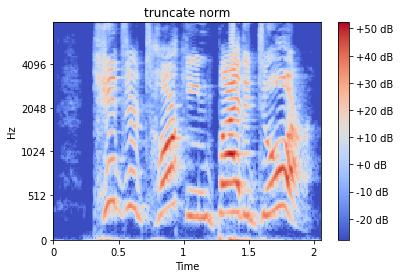

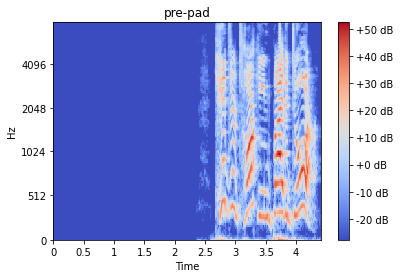

In [15]:
test_spec = mel_spectral_decomposition(test_sample,test_rate, visualise = True, title = 'original')
plt.figure()
test_spec = mel_spectral_decomposition(truncate_silence(test_sample),test_rate, visualise = True, title = 'truncate')
plt.figure()
test_spec = mel_spectral_decomposition(test_sample_tr,test_rate, visualise = True, title = 'truncate norm')

plt.figure()
test_spec = mel_spectral_decomposition(test_sample_pad,test_rate, visualise = True, title = 'pre-pad')

Apply padding and truncation on all the data.

In [16]:
def load_samples(max_sample, padding = True, truncating = True, normal = True, duration = None):
  # load samples
  X = []
  y = []

  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01' or sample_name[6:8] == '01':
          continue

        sample, sampling_rate = librosa.load(sample_path, sr = 16000)
        
        truncated_sample = sample

        

        if truncating:
          truncated_sample = truncate_silence(sample)
        
        diff_duration = None
        if duration != None:
          total_duration = truncated_sample.shape[0]
          diff_duration = total_duration - (duration * sampling_rate)

        if normal:
          truncated_sample = amp_normalisation(truncated_sample)
        

        padded_sample = truncated_sample

        if padding:
          if diff_duration == None:

            padded_sample = pre_pad(truncated_sample, max_sample)
          
          elif diff_duration < 0:
            padded_sample = pre_pad(truncated_sample, int(duration * sampling_rate))
          

        if duration != None:
          spectrogram = mel_spectral_decomposition(padded_sample[:int(sampling_rate * duration)], sampling_rate)
        else:
          spectrogram = mel_spectral_decomposition(padded_sample, sampling_rate)
        
        target = target_generation(sample_name)

        if target != None:
          X.append(spectrogram)
          y.append(target)
  
  return X, y

__Conditional padding__: We do not want to pad the example with zeros to the maixmum length. This might cause problems as the padded zeros might take half of the total time duration. See above for the padded figure. 

Instead, we want to see a maximum duration for each sample to load. e.g. 2 seconds. This means that any samples exceeding 2 second duration will be truncated at the 2second mark. 

In [17]:
X,y = load_samples(max_sample, padding = True, truncating = True, normal = True, duration = 2)

In [18]:
X = np.array(X)

In [19]:
X.shape

(240, 128, 63)

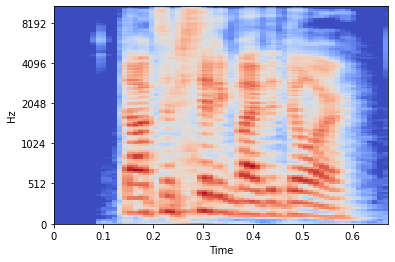

In [20]:
# quick inspect
librosa.display.specshow(X[10], y_axis='mel', fmax=None, x_axis='time', sr =48000)

## Clean-up data
1. Truncate X to be the proper size. detail below
2. vectorised y

In [21]:
def vectorise(y):
  '''
  Vectorise the digit label target to a binary vector
  Parameter:
  ----------
      y: torch.tensor
          The target vector of MNIST dataset

  Returns:
  --------
    vectorised_y: torch.tensor
        Vectorised version of y
  '''
  num_digits = 5

  one_hot_tensor = []
  for target in y:
    one_hot = np.array([0 for i in range(num_digits)])
    one_hot[target] = 1
    one_hot_tensor.append(one_hot)
  
  vectorised_y = torch.tensor(one_hot_tensor)

  return vectorised_y

In [22]:
# convert torch type
X = torch.tensor(X)


# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

y = torch.tensor(y)

#one-hot y
#y = vectorise(y)

# Architecture building

1. build a CNN

## CNN

In [23]:
# convolutional net

# input: 128xtime_steps
#output: 30x14 for 32 filters
class ConvNet(nn.Module):
    def __init__(self, contain_linear = False):
        super(ConvNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

        if contain_linear:
          self.linear = nn.Sequential(
              nn.Linear(32*30*14, 1000),
              nn.Linear(1000, 5),
          )

    def forward(self, x, inspect_feature = False):

      conv_x = self.conv(x)
      conv_x_flat  = self.flatten(conv_x)
      linear_x = self.linear(conv_x_flat)
      
      if inspect_feature:
        return conv_x,linear_x
      return linear_x


In [24]:
# example usage
CNN = ConvNet(contain_linear = True)
cnn_out = CNN(X[:30], inspect_feature = False)

In [25]:
cnn_out

tensor([[ 4.0173e-01,  4.5404e-01, -7.5020e-01, -6.0338e-01,  1.3621e+00],
        [ 9.1494e-01,  5.9175e-01, -8.3993e-01, -8.0458e-01,  1.9860e+00],
        [ 1.6890e+00,  1.5471e+00, -4.4775e-01, -6.9678e-01,  1.1243e+00],
        [-5.5057e-01, -8.3010e-01, -6.7780e-01, -1.2025e+00,  9.4943e-01],
        [-1.7006e-01,  5.9127e-01,  2.1762e-01, -4.5740e-01,  2.0380e+00],
        [ 1.4640e+00, -1.8284e+00, -5.0951e-01, -7.5132e-02,  2.4274e+00],
        [ 4.8430e-02, -9.5445e-01,  4.5874e-01, -4.2671e-01,  1.2374e+00],
        [-7.2703e-01, -4.4231e-01, -4.6016e-01,  8.0409e-01, -1.2729e-01],
        [-1.8398e-01, -1.5021e+00,  4.7283e-01, -2.1714e+00,  2.0722e+00],
        [ 5.4525e-01,  2.6072e-01, -9.9063e-01, -5.7008e-01,  1.7030e+00],
        [ 1.7398e+00, -3.2613e-02,  5.4061e-01,  1.3505e+00,  6.0685e-01],
        [ 7.0877e-01,  6.8312e-01, -7.7614e-02, -1.3613e+00,  1.1321e+00],
        [-5.1380e-01,  1.1869e+00, -6.9457e-01, -7.9316e-02,  1.7104e+00],
        [ 6.9869e-01, -3.

# Training
Now we attempt to train on some datasets and see how it performs.
* Loss function: softmax
* learning rate = 0.01

In [26]:
class DatasetWrapper(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
  def change_type(self, dtype):

    return DatasetWrapper(self.X.type(dtype),self.y.type(dtype))
  
  def dataset(self):
    return DatasetWrapper(self.X,self.y)
  
  def get_data(self):
    return self.X, self.y

In [37]:
def train_model(data, net, loss, nepoch ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.SGD(net.parameters(), lr = lr)
  data = data.dataset.change_type(dtype)

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = num_samples, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)
    
  for epoch in range(nepoch):
     for X_batch, y_batch in data_loader:
      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive


      pred = net(X_batch)
      Rn = loss(pred, y_batch)
      Rn.backward()
      optimizer.step()
     if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
  
  print('final loss:', Rn.item())
  
  return net

In [38]:
# just CNN
spectro_data = DatasetWrapper(X,y)
train_size = int(X.shape[0] * 0.7)
test_size = X.shape[0] - train_size

loss = nn.CrossEntropyLoss()

data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))

CNN = ConvNet(contain_linear = True)
nepoch = 100
batch_size = 30

trained_net = train_model(data_train,CNN, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = False)

final loss: 0.0006179278716444969


# Testing

In [39]:
def classification(prediction):
  classified = torch.argmax(prediction, dim = 1)
  return classified

def accuracy(y_pred, y_test):
  class_pred = classification(y_pred)

  accuracy = class_pred == y_test

  accuracy_percent = torch.count_nonzero(accuracy)/accuracy.shape[0]
  return accuracy_percent.item()


In [40]:
X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)
accuracy_score = accuracy(y_pred,y_test)
print('accuracy:' + str(accuracy_score))

accuracy:1.0
